In [67]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, to_dense_adj, to_networkx
import sys
#add path to utils
sys.path.append('../../')
from utils import GraphDatasetV3, reconstruct_matrix, outputs_to_networkx, evaluate_all
from networks.graph_vae import GRAPH_VAE
from networks.graph_vae_v3 import GRAPH_VAE_V3
# from networks.gae import GRAPH_VAE_V3
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import argparse
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import negative_sampling
import itertools
import matplotlib.colors as mcolors

In [68]:
dataset = GraphDatasetV3(root='../../../data/sub20/graphs')

In [69]:
# Define the parameters
params = {
    'distribution_std': 1.0,
    'variational_beta': 0.01,
    'capacity': 256,
    'dec_layers': 4,
    'edge_layers': 4,
    "edge_pos_weight": 5.4,   # you already use this
    "edge_neg_weight": 2.0,    # NEW: >1 penalizes negatives → higher precision
    "edge_loss_lambda": 1.5,
}

In [70]:
device = torch.device('cpu')
input_dim = 5 #dataset.num_features
latent_dim = 128
model = GRAPH_VAE_V3(input_dim=input_dim, latent_dim=latent_dim, params=params, template=dataset.template, ).to(device)
# Load weights
model.load_state_dict(torch.load(f"../../networks/weights/GRAPH_VAE_V3_latent=128_lr=0.0002_epochs=1000_variational_beta=0.05_capacity=256_dec_layers=4_edge_layers=4_best.pt")["model_state_dict"])

/tmp/ipykernel_547133/862407122.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../networks/weights/GRAPH_VAE_V3_latent=128_lr=0.00

<All keys matched successfully>

In [71]:
# Create the DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)
# Split the dataset into training, validation, and test sets
print("Splitting the dataset")
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Val size: {val_size}")

# Seed split
SEED = 12345
g_split = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g_split)


Splitting the dataset
Train size: 39300, Val size: 4912


In [ ]:
@torch.no_grad()
def collect_edge_scores(model, loader, template, device):
    """Collect edge logits and labels across a loader, using your existing masking logic."""
    model.eval()
    logits_all, labels_all = [], []

    node_dir_to_e   = template.node_dir_to_e.to(device)      # [N,8]
    node_dir_to_dst = template.node_dir_to_dst.to(device)    # [N,8]
    valid_nd = (node_dir_to_e >= 0)
    nd_pos = valid_nd.nonzero(as_tuple=False)                 # [M,2]
    idx_flat = (nd_pos[:, 0] * 8 + nd_pos[:, 1]).to(device)   # [M]
    e_idx = node_dir_to_e[valid_nd]                           # [M]

    for batch in loader:
        batch = batch.to(device)
        output, mu, logvar = model(batch.x, batch.edge_index_enc, batch.batch)
        _, edges8, _, _, _ = output  # [B,N,8]
        B = batch.num_graphs
        N = template.Nmax
        E = template.edge_index_cand.size(1)

        y_node  = batch.y_node_present.view(B, N).to(device)   # [B,N]
        y_edgeE = batch.y_edge.view(B, E).to(device)           # [B,E]

        # labels for valid (node,dir)
        y_edge_valid = y_edgeE.gather(1, e_idx.unsqueeze(0).expand(B, -1))  # [B,M]

        # both endpoints exist in GT
        dst_idx_safe = node_dir_to_dst.clamp_min(0)
        y_node_exp   = y_node.unsqueeze(-1).expand(-1, -1, 8)              # [B,N,8]
        idx_for_gath = dst_idx_safe.unsqueeze(0).expand(B, -1, -1)         # [B,N,8]
        y_dst        = torch.gather(y_node_exp, 1, idx_for_gath)           # [B,N,8]
        both_exist   = (y_node.unsqueeze(-1) == 1) & (y_dst == 1) & valid_nd.unsqueeze(0)  # [B,N,8]

        edges8_flat    = edges8.view(B, -1)                      # [B,N*8]
        logits_valid   = edges8_flat.index_select(1, idx_flat)   # [B,M]
        both_exist_flat= both_exist.view(B, -1).index_select(1, idx_flat)  # [B,M]

        if both_exist_flat.any():
            logits_keep = logits_valid[both_exist_flat].detach().cpu()
            labels_keep = y_edge_valid[both_exist_flat].detach().cpu()
            logits_all.append(logits_keep)
            labels_all.append(labels_keep)

    if len(logits_all) == 0:
        return np.array([]), np.array([])
    logits = torch.cat(logits_all, dim=0).numpy()
    labels = torch.cat(labels_all, dim=0).numpy()
    return logits, labels


In [73]:
@torch.no_grad()
def sweep_edge_thresholds_from_scores(logits, labels, target_min=0.9, num_points=101, save_png=None):
    """
    Given raw logits and binary labels, sweep thresholds in [0,1].
    Returns dict with arrays and a suggested best threshold.
    """
    if logits.size == 0:
        raise ValueError("No edge scores collected (empty logits).")

    probs = 1.0 / (1.0 + np.exp(-logits))
    ths   = np.linspace(0.0, 1.0, num_points)

    precs, recs, f1s, accs = [], [], [], []
    for t in ths:
        pred = (probs >= t)
        tp = np.sum((pred==1) & (labels==1))
        fp = np.sum((pred==1) & (labels==0))
        fn = np.sum((pred==0) & (labels==1))
        tn = np.sum((pred==0) & (labels==0))
        prec = tp / max(1, (tp+fp))
        rec  = tp / max(1, (tp+fn))
        f1   = 2*prec*rec / max(1e-12, (prec+rec))
        acc  = (tp+tn) / max(1, (tp+fp+fn+tn))
        precs.append(prec); recs.append(rec); f1s.append(f1); accs.append(acc)

    precs = np.array(precs); recs = np.array(recs); f1s = np.array(f1s); accs = np.array(accs)

    # choose threshold:
    # 1) try to meet both precision >= target_min and recall >= target_min
    ok = (precs >= target_min) & (recs >= target_min)
    if ok.any():
        # among those, pick maximum F1
        idx = np.argmax(f1s * ok)
    else:
        # fall back to max F1
        idx = np.argmax(f1s)
    best_thr = float(ths[idx])

    # optional plot
    if save_png is not None:
        plt.figure(figsize=(7,5))
        plt.plot(ths, precs, label="precision")
        plt.plot(ths, recs,  label="recall")
        plt.plot(ths, f1s,   label="F1")
        plt.plot(ths, accs,  label="accuracy", linestyle="--", alpha=0.6)
        plt.axvline(best_thr, color='k', linestyle=':', label=f"best thr={best_thr:.2f}")
        plt.xlabel("Edge threshold"); plt.ylabel("Metric")
        plt.ylim(0, 1.05); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.savefig(save_png); plt.close()

    return {
        "thresholds": ths,
        "precision":  precs,
        "recall":     recs,
        "f1":         f1s,
        "accuracy":   accs,
        "best_thr":   best_thr,
        "best_row":   {"precision": float(precs[idx]), "recall": float(recs[idx]),
                       "f1": float(f1s[idx]), "accuracy": float(accs[idx])}
    }


In [74]:
# 1) Collect scores on your validation set
device = torch.device('cuda')
model.to(device)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
logits, labels = collect_edge_scores(model, val_loader, dataset.template, device)

# 2) Sweep and plot
res = sweep_edge_thresholds_from_scores(
    logits, labels, target_min=0.90,
    save_png=f"./{model.name}_edge_threshold_sweep.png"
)
print("Best threshold:", res["best_thr"])
print("Metrics @ best:", res["best_row"])

# 3) Re-evaluate at that threshold
metrics_at_best = evaluate_all(model, val_loader, dataset.template, device, edge_thr=res["best_thr"])
print(metrics_at_best["edge_precision"], metrics_at_best["edge_recall"], metrics_at_best["edge_f1"])


Best threshold: 0.72
Metrics @ best: {'precision': 0.9132938760067023, 'recall': 0.9304014411980371, 'f1': 0.9217682884417894, 'accuracy': 0.9752652111757372}
0.9132938760067023 0.9304014411980371 0.9217682884417894


In [75]:
model.eval()
device = torch.device('cpu')
model.to(device)
picked_G = None
for batch in loader:
    
    batch = batch.to(device)
    # use edge_index_enc if present; else fall back to edge_index
    edge_index_enc = getattr(batch, "edge_index_enc", batch.edge_index)
    output, mu, logvar = model(batch.x, edge_index_enc, batch.batch)

    # reconstruct NX graph from the model outputs
    G = outputs_to_networkx(model, output=output, tau_node=0.5, tau_edge=0.72, gate_mode="logit")

    # replicate your “pick a mid-sized graph” filter (50 < #nodes < 60)
    if 10 < G.number_of_nodes() < 30:
        picked_G = G
        break


/tmp/ipykernel_547133/1903976784.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


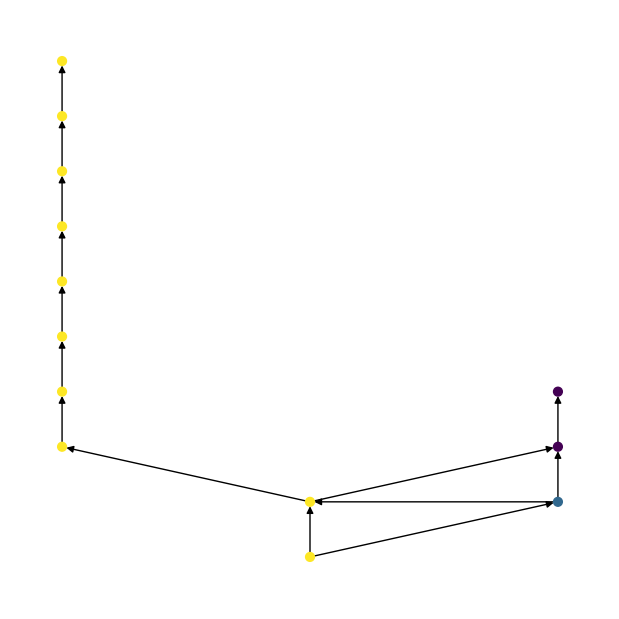

In [76]:
if picked_G is None:
    # fall back to the last one
    picked_G = G

# position nodes by (col,row) or normalized positions
pos = {n: (picked_G.nodes[n]["col"], -picked_G.nodes[n]["row"]) for n in picked_G.nodes}
plt.figure(figsize=(6,6))
nx.draw(
    picked_G, pos,
    node_size=40,
    arrows=True,
    with_labels=False,
    node_color=[picked_G.nodes[n]["fuel"] for n in picked_G.nodes],  # color by fuel class
    cmap="viridis",
)
plt.tight_layout()
plt.show()

In [77]:
# check number of connected components, turn into undirected graph
G_ = G.to_undirected()
print(nx.number_connected_components(G_))


1


In [78]:
import torch
import networkx as nx

def batch_to_real_nx(
    batch,
    template,
    b: int = 0,                    # which item in the batch (use 0 if batch_size=1)
    prune_isolates: bool = True,
    prefer_y_edge: bool = True,    # prefer canonical labels y_edge over edge_index
) -> nx.DiGraph:
    """
    Build the ground-truth DiGraph aligned to canonical slot ids (0..Nmax-1).

    Priority for edges:
      1) y_edge (canonical labels) + template.edge_index_cand
      2) batch.edge_index mapped via batch.original_ids
      3) batch.edge_index_enc mapped via batch.original_ids (fallback; may be induced)

    Nodes:
      - If y_node_present exists → use slots with label==1.
      - Else → infer from edge endpoints.

    Returns an nx.DiGraph with nodes as canonical slots.
    """
    G = nx.DiGraph()
    N = template.Nmax
    E = template.edge_index_cand.size(1)

    # --- Node set (prefer ground-truth presence if available) ---
    nodes_added = False
    if hasattr(batch, "y_node_present"):
        y_node = batch.y_node_present
        if y_node.dim() == 1:
            present = (y_node == 1).nonzero(as_tuple=False).view(-1)
        else:
            present = (y_node.view(batch.num_graphs, N)[b] == 1).nonzero(as_tuple=False).view(-1)
        node_list = [int(i.item()) for i in present]
        if node_list:
            G.add_nodes_from(node_list)
            nodes_added = True

    # --- Edges (prefer canonical y_edge if available) ---
    edges_added = False
    if prefer_y_edge and hasattr(batch, "y_edge"):
        y_edge = batch.y_edge
        if y_edge.dim() == 1:
            ye = y_edge
        else:
            ye = y_edge.view(batch.num_graphs, E)[b]
        e_idx = (ye == 1).nonzero(as_tuple=False).view(-1)
        if e_idx.numel() > 0:
            ei = template.edge_index_cand[:, e_idx]  # [2, M]
            src = ei[0].tolist()
            dst = ei[1].tolist()
            G.add_edges_from((int(s), int(t)) for s, t in zip(src, dst))
            edges_added = True

    # fallback: use true edge_index mapped by original_ids
    if (not edges_added) and (getattr(batch, "edge_index", None) is not None) and hasattr(batch, "original_ids"):
        src_local = batch.edge_index[0]
        dst_local = batch.edge_index[1]
        src = batch.original_ids[src_local].long().cpu().tolist()
        dst = batch.original_ids[dst_local].long().cpu().tolist()
        G.add_edges_from((int(s), int(t)) for s, t in zip(src, dst))
        edges_added = True

    # last resort: edge_index_enc (may be induced neighbors)
    if (not edges_added) and (getattr(batch, "edge_index_enc", None) is not None) and hasattr(batch, "original_ids"):
        src_local = batch.edge_index_enc[0]
        dst_local = batch.edge_index_enc[1]
        src = batch.original_ids[src_local].long().cpu().tolist()
        dst = batch.original_ids[dst_local].long().cpu().tolist()
        G.add_edges_from((int(s), int(t)) for s, t in zip(src, dst))
        edges_added = True

    # If we have edges but no nodes yet, add endpoints as nodes
    if (not nodes_added) and edges_added:
        endpoints = set()
        endpoints.update(u for u, _ in G.edges())
        endpoints.update(v for _, v in G.edges())
        if endpoints:
            G.add_nodes_from(endpoints)

    # Optionally prune isolates
    if prune_isolates:
        G.remove_nodes_from(list(nx.isolates(G)))

    return G

# use the template you already have on the model
G_real = batch_to_real_nx(batch, template=model.template, prune_isolates=True)

# compare edges with your predicted G
edges_G      = set(G.edges())
edges_G_real = set(G_real.edges())
unique_to_G       = edges_G - edges_G_real
unique_to_G_real  = edges_G_real - edges_G


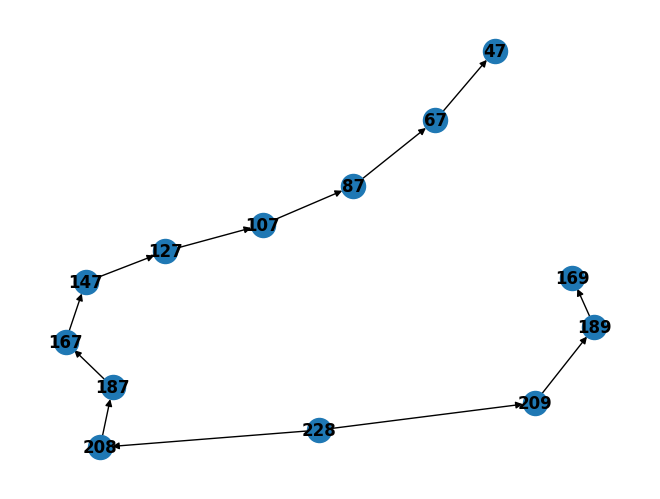

In [79]:
# draw graph
# drop unconnected nodes
G_real.remove_nodes_from(list(nx.isolates(G_real)))
pos = nx.spring_layout(G_real)
# draw with labels
nx.draw(G_real, pos, font_weight='bold', labels={node: str(node) for node in G_real.nodes()})
plt.show()

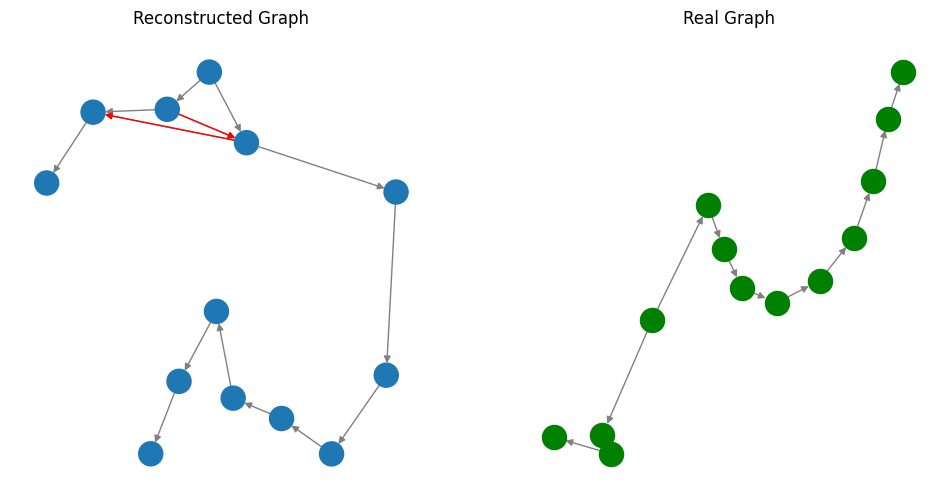

In [80]:
# Find connected components in the reconstructed graph
components = list(nx.weakly_connected_components(G))
colors = itertools.cycle(['#1f78b4', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow'])

# Assign a color to each node based on its component
node_colors = {}
for component, color in zip(components, colors):
    for node in component:
        node_colors[node] = color

# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph
pos = nx.spring_layout(G)
nx.draw(G, pos, ax=axes[0], with_labels=False, node_color=[node_colors[node] for node in G.nodes()], edge_color='gray')
if unique_to_G:
    nx.draw_networkx_edges(G, pos, edgelist=unique_to_G, edge_color='red', ax=axes[0])
axes[0].set_title('Reconstructed Graph')

# Plot the real graph
pos_real = nx.spring_layout(G_real)
G_real.remove_nodes_from(list(nx.isolates(G_real)))
nx.draw(G_real, pos_real, ax=axes[1], with_labels=False, node_color='green', edge_color='gray')
if unique_to_G_real:
    nx.draw_networkx_edges(G_real, pos_real, edgelist=unique_to_G_real, edge_color='red', ax=axes[1])
axes[1].set_title('Real Graph')

plt.show()

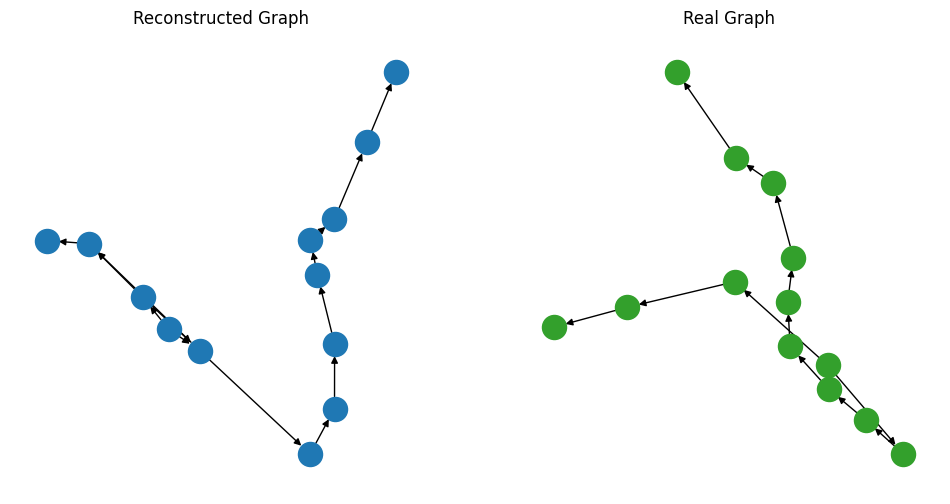

In [81]:
# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph using the default layout
nx.draw(G, ax=axes[0], with_labels=False, node_color='#1f78b4', edge_color='black')  # Blue color
axes[0].set_title('Reconstructed Graph')

# Plot the real graph using the default layout
nx.draw(G_real, ax=axes[1], with_labels=False, node_color='#33a02c', edge_color='black')  # Green color
axes[1].set_title('Real Graph')

plt.show()